In [2]:
import numpy as np
import os
import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

import tensorflow as tf
from tensorflow.keras import layers

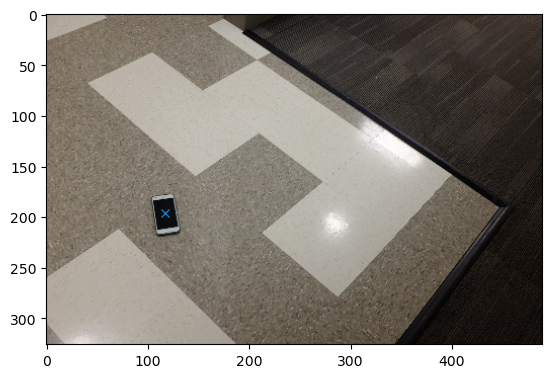

In [4]:
img = mpimg.imread('find_phone/51.jpg')
img = img/255.
plt.plot([490*0.2388],[326*0.6012],'x')
plt.imshow(img)

In [5]:
img.max(), img.min()

(1.0, 0.0)

In [6]:
metadata = []
with open("find_phone/labels.txt","r") as f:
    data = f.readline()
    while data:
        metadata.append(data.strip().split(" "))
        #filename, x, y = data.strip().split(" ")
#         np.append(X,mpimg.imread('find_phone/'+filename))
#         np.append(Y,[x,y])
        data = f.readline()

In [7]:
img.shape

(326, 490, 3)

In [25]:
# Creating a dataset
x, x_gray, y = np.zeros((len(metadata),326,490,3)), np.zeros((len(metadata),326,490)), np.empty((len(metadata),2))
for i,data in enumerate(metadata):
    img = mpimg.imread('find_phone/'+data[0])
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.
    img_gray = img_gray/255.
    x[i,:,:,:] = img
    x_gray[i,:,:] = img_gray
    y[i,0], y[i,1] = np.float(data[1]), np.float(data[2])

/var/folders/q6/43vsmv9x2pz_q1psr6pkrlyh0000gn/T/ipykernel_1110/3221055654.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y[i,0], y[i,1] = np.float(data[1]), np.float(data[2])


In [26]:
# Scaling y images
y_scaled = y.copy()
y_scaled[:,0] = 490*y_scaled[:,0]
y_scaled[:,1] = 326*y_scaled[:,1]

## 1. PCA with SVR

In [27]:
x.shape, y.shape

((129, 326, 490, 3), (129, 2))

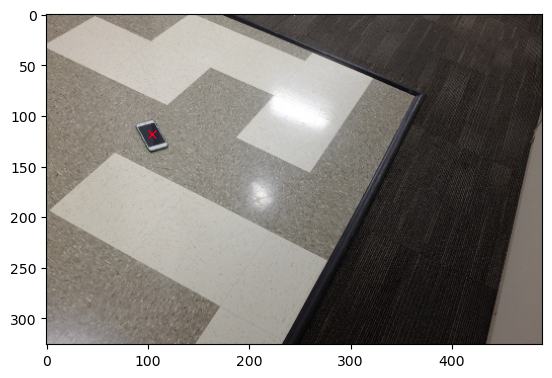

In [43]:
# Checking if the scaled and normal values align
idx = 100
plt.plot([490*y[idx,0]], [326*y[idx,1]],'bx')
plt.plot([y_scaled[idx,0]], [y_scaled[idx,1]],'rx')
plt.imshow(x[idx,:,:,:], cmap="gray")

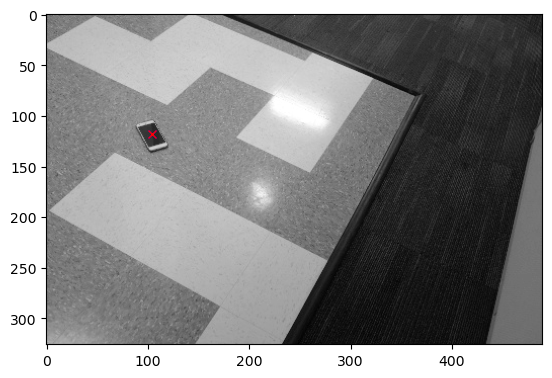

In [44]:
# Checking for gray scale image
idx = 100
plt.plot([490*y[idx,0]], [326*y[idx,1]],'bx')
plt.plot([y_scaled[idx,0]], [y_scaled[idx,1]],'rx')
plt.imshow(x_gray[idx,:,:], cmap="gray")

In [45]:
y[idx,0],y[idx,1]

(0.2122, 0.362)

In [46]:
# Flatten the image for PCA into 2D
x_gray_flat = x_gray.reshape((len(metadata),-1))
x_flat = x.reshape((len(metadata),-1))
x_gray_flat.shape, x_flat.shape

((129, 159740), (129, 479220))

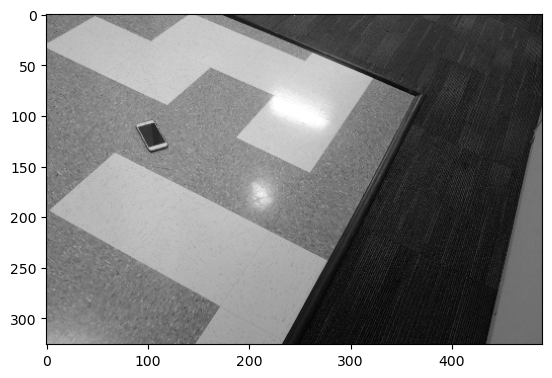

In [47]:
# Checking if the flattened image is rightly aligned
plt.imshow(x_gray_flat[idx].reshape(326,490), cmap="gray")

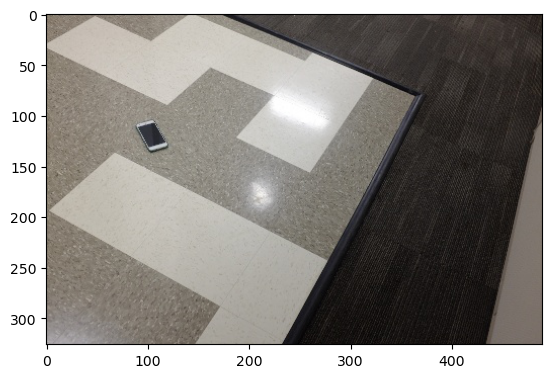

In [48]:
plt.imshow(x_flat[idx].reshape(326,490,3), cmap="gray")

In [58]:
# PCA
pca = PCA(n_components=100, whiten=True)
x_trans = pca.fit_transform(x_gray_flat)
x_trans.shape

(129, 100)

In [59]:
# Reduces from (129, 479220) -> (129, 100) and explains 98% of data
pca.explained_variance_ratio_.sum()

0.9839265113544846

In [60]:
pca.components_.shape

(100, 159740)

In [65]:
idx=100
n_comps = 100
rec_img = np.zeros((326,490))
coeffs = x_trans[idx]

for i in range(n_comps):
    rec_img += coeffs[i]*pca.components_[i].reshape(326,490)


In [66]:
rec_img.max(), rec_img.min(),x_flat.min()

(0.08275191904052213, -0.09602874519523703, 0.0)

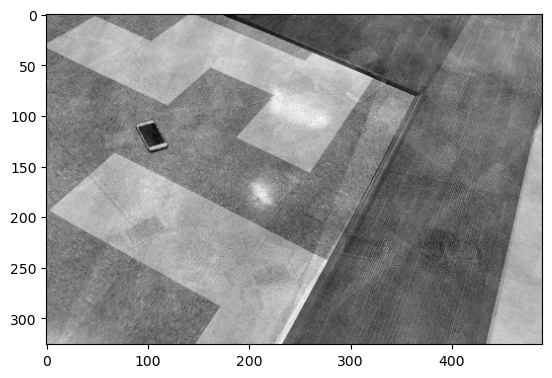

In [67]:
plt.imshow(rec_img, cmap="gray")

In [74]:
# Train test split
x_gray_train_pca, y_gray_train_pca, x_gray_test_pca, y_gray_test_pca = split_data(x_trans, y_scaled, test_frac=0.3)
x_gray_train_pca.shape, y_gray_test_pca.shape

((90, 100), (39, 2))

In [75]:
# Running SVM Regression, for 'x' coordinate with gray images
x_md = SVR()
x_md.fit(x_gray_train_pca, y_gray_train_pca[:,0])
y_pred_x = x_md.predict(x_gray_test_pca)
mse(y_gray_test_pca[:,0],y_pred_x)

14514.343002720909

In [76]:
# Running SVM Regression, for 'y' coordinate with gray images
y_md = SVR()
y_md.fit(x_gray_train_pca, y_gray_train_pca[:,1])
y_pred_y = y_md.predict(x_gray_test_pca)
mse(y_gray_test_pca[:,1]*326,y_pred_y)

3427324763.110736

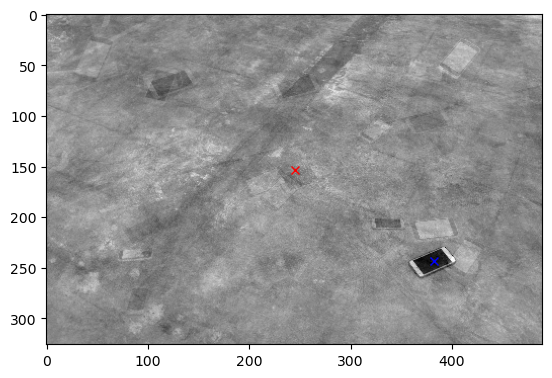

In [80]:
# Visualise on test
idx = 2
n_comps = 95
rec_img = np.zeros((326,490))
coeffs = x_gray_test_pca[idx]

for i in range(n_comps):
    rec_img += coeffs[i]*pca.components_[i].reshape(326,490)

plt.plot([y_pred_x[idx]], [y_pred_y[idx]],'rx',)
plt.plot([y_gray_test_pca[idx,0]], [y_gray_test_pca[idx,1]],'bx')
plt.imshow(rec_img, cmap="gray")

In [81]:
y_pred_x[idx], y_pred_y[idx], y_gray_test_pca[idx,0], y_gray_test_pca[idx,1]

(245.39915520765993,
 153.16522869769685,
 382.00399999999996,
 243.00039999999998)

In [82]:
# Visualise on train
y_pred_xtrain = x_md.predict(x_gray_train_pca)
mse(y_gray_train_pca[:,0],y_pred_xtrain)

12846.36281404467

In [84]:
y_pred_ytrain = y_md.predict(x_gray_train_pca)
mse(y_gray_train_pca[:,1],y_pred_ytrain)

5645.691933895104

High error for both the train and the test data. So the model is not able to learn.

## 2. FCN

### 2.1 Using PCA data

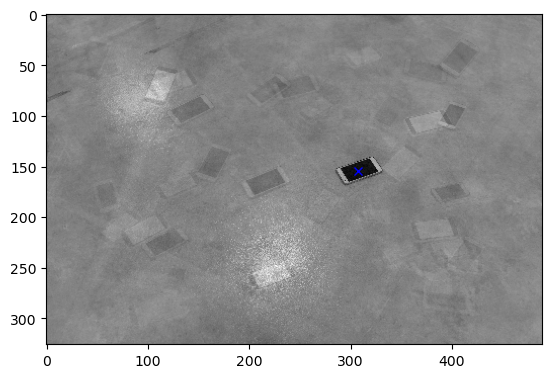

In [29]:
# Testing the train data
idx = 1
n_comps = 95
rec_img = np.zeros((326,490))
coeffs = x_train_pca[idx]

for i in range(n_comps):
    rec_img += coeffs[i]*pca.components_[i].reshape(326,490)

#plt.plot([y_pred_x[idx]], [y_pred_y[idx]],'rx',)
plt.plot([490*y_train_pca[idx,0]], [326*y_train_pca[idx,1]],'bx')
plt.imshow(rec_img, cmap="gray")

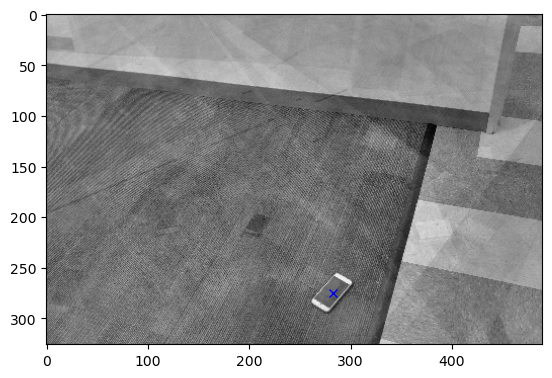

In [30]:
# Testing the test data
idx = 1
n_comps = 95
rec_img = np.zeros((326,490))
coeffs = x_test_pca[idx]

for i in range(n_comps):
    rec_img += coeffs[i]*pca.components_[i].reshape(326,490)

plt.plot([490*y_test_pca[idx,0]], [326*y_test_pca[idx,1]],'bx')
plt.imshow(rec_img, cmap="gray")

In [103]:
fc_model = build_model("FC",x_trans.shape)
fc_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 16)                1616      
                                                                 
 dense_16 (Dense)            (None, 32)                544       
                                                                 
 dense_17 (Dense)            (None, 2)                 66        
                                                                 
Total params: 2,226
Trainable params: 2,226
Non-trainable params: 0
_________________________________________________________________


In [104]:
# train the model
n_epochs=200
pca_history = fc_model.fit(x_trans,
                          y_scaled,
                          epochs=n_epochs,
                          validation_split=0.3,
                          verbose=True)

Epoch 1/200
1/3 [=========>....................] - ETA: 0s - loss: 62298.9609 - mse: 62298.9609

2023-03-02 18:50:19.179972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 81ms/step - loss: 55007.1914 - mse: 55007.1914 - val_loss: 44360.8203 - val_mse: 44360.8203
Epoch 2/200
3/3 [==============================] - 0s 20ms/step - loss: 54952.8828 - mse: 54952.8789 - val_loss: 44326.7812 - val_mse: 44326.7812
Epoch 3/200
3/3 [==============================] - 0s 19ms/step - loss: 54900.0000 - mse: 54900.0000 - val_loss: 44292.5469 - val_mse: 44292.5469
Epoch 4/200
1/3 [=========>....................] - ETA: 0s - loss: 52491.3984 - mse: 52491.3984

2023-03-02 18:50:19.392550: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 20ms/step - loss: 54846.9883 - mse: 54846.9883 - val_loss: 44257.7891 - val_mse: 44257.7891
Epoch 5/200
3/3 [==============================] - 0s 18ms/step - loss: 54793.6797 - mse: 54793.6797 - val_loss: 44222.3984 - val_mse: 44222.3984
Epoch 6/200
3/3 [==============================] - 0s 18ms/step - loss: 54739.5586 - mse: 54739.5586 - val_loss: 44186.4375 - val_mse: 44186.4375
Epoch 7/200
3/3 [==============================] - 0s 19ms/step - loss: 54686.0234 - mse: 54686.0234 - val_loss: 44149.6875 - val_mse: 44149.6836
Epoch 8/200
3/3 [==============================] - 0s 18ms/step - loss: 54626.2227 - mse: 54626.2227 - val_loss: 44112.6602 - val_mse: 44112.6602
Epoch 9/200
3/3 [==============================] - 0s 18ms/step - loss: 54567.6445 - mse: 54567.6445 - val_loss: 44074.5508 - val_mse: 44074.5508
Epoch 10/200
3/3 [==============================] - 0s 18ms/step - loss: 54503.7773 - mse: 54503.7773 - val_loss: 44035.4688 - val_mse: 

Epoch 60/200
3/3 [==============================] - 0s 17ms/step - loss: 38364.7109 - mse: 38364.7109 - val_loss: 38575.5312 - val_mse: 38575.5312
Epoch 61/200
3/3 [==============================] - 0s 17ms/step - loss: 37644.5508 - mse: 37644.5469 - val_loss: 38385.1367 - val_mse: 38385.1367
Epoch 62/200
3/3 [==============================] - 0s 17ms/step - loss: 36882.0273 - mse: 36882.0273 - val_loss: 38194.1602 - val_mse: 38194.1602
Epoch 63/200
3/3 [==============================] - 0s 17ms/step - loss: 36128.9414 - mse: 36128.9414 - val_loss: 37997.4922 - val_mse: 37997.4922
Epoch 64/200
3/3 [==============================] - 0s 16ms/step - loss: 35328.2539 - mse: 35328.2539 - val_loss: 37800.9180 - val_mse: 37800.9180
Epoch 65/200
3/3 [==============================] - 0s 17ms/step - loss: 34521.1250 - mse: 34521.1250 - val_loss: 37602.8242 - val_mse: 37602.8242
Epoch 66/200
3/3 [==============================] - 0s 17ms/step - loss: 33748.3906 - mse: 33748.3906 - val_loss: 3740

Epoch 116/200
3/3 [==============================] - 0s 17ms/step - loss: 7272.4736 - mse: 7272.4736 - val_loss: 29304.2402 - val_mse: 29304.2383
Epoch 117/200
3/3 [==============================] - 0s 18ms/step - loss: 7138.5801 - mse: 7138.5801 - val_loss: 29223.7246 - val_mse: 29223.7246
Epoch 118/200
3/3 [==============================] - 0s 17ms/step - loss: 7027.9141 - mse: 7027.9141 - val_loss: 29145.4805 - val_mse: 29145.4805
Epoch 119/200
3/3 [==============================] - 0s 17ms/step - loss: 6906.2334 - mse: 6906.2334 - val_loss: 29070.4043 - val_mse: 29070.4043
Epoch 120/200
3/3 [==============================] - 0s 18ms/step - loss: 6788.5552 - mse: 6788.5552 - val_loss: 28998.9785 - val_mse: 28998.9785
Epoch 121/200
3/3 [==============================] - 0s 17ms/step - loss: 6679.3828 - mse: 6679.3823 - val_loss: 28930.5254 - val_mse: 28930.5254
Epoch 122/200
3/3 [==============================] - 0s 17ms/step - loss: 6578.7397 - mse: 6578.7397 - val_loss: 28861.5996 

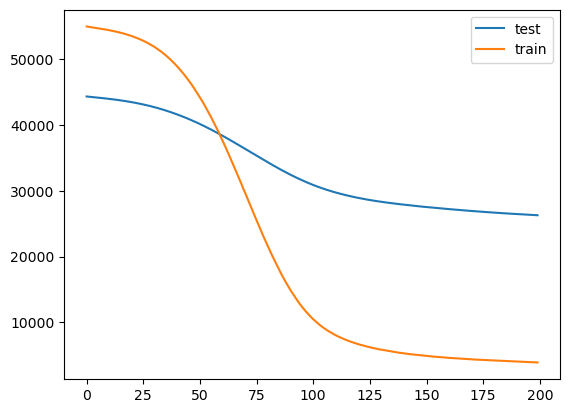

In [105]:
plt.plot(range(n_epochs),pca_history.history['val_mse'], label="test")
plt.plot(range(n_epochs),pca_history.history['mse'], label="train")
plt.legend()

In [106]:
y_pred = fc_model.predict(x_trans)

5/5 [==============================] - 0s 8ms/step


2023-03-02 18:51:00.310898: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [107]:
y_pred.shape

(129, 2)

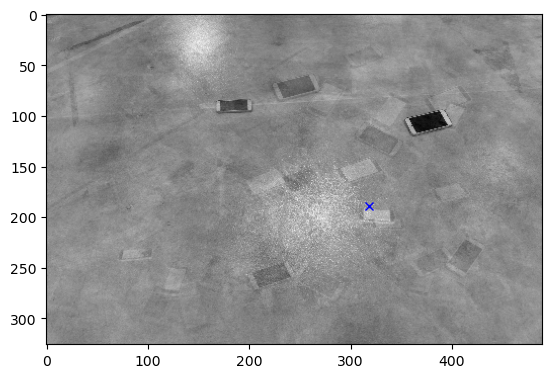

In [113]:
# Testing the test data
idx = 4
n_comps = n_comps
rec_img = np.zeros((326,490))
coeffs = x_trans[idx]

for i in range(n_comps):
    rec_img += coeffs[i]*pca.components_[i].reshape(326,490)

plt.plot([y_pred[idx,0]], [y_pred[idx,1]],'bx')
plt.imshow(rec_img, cmap="gray")

### 2.2) Using Raw Image

In [123]:
fc_model_raw = build_model("FC",x_flat.shape)
fc_model_raw.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 8)                 3833768   
                                                                 
 dense_22 (Dense)            (None, 8)                 72        
                                                                 
 dense_23 (Dense)            (None, 2)                 18        
                                                                 
Total params: 3,833,858
Trainable params: 3,833,858
Non-trainable params: 0
_________________________________________________________________


In [124]:
# train the model
n_epochs=75
raw_history = fc_model_raw.fit(x_flat,
                          y_scaled,
                          epochs=n_epochs,
                          validation_split=0.3,
                          verbose=True)

Epoch 1/75


2023-03-02 18:55:34.626345: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 1s 212ms/step - loss: 28452.7031 - mse: 28452.7031 - val_loss: 35709.8203 - val_mse: 35709.8203
Epoch 2/75
1/3 [=========>....................] - ETA: 0s - loss: 32117.2266 - mse: 32117.2266

2023-03-02 18:55:35.222682: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 85ms/step - loss: 28381.4316 - mse: 28381.4316 - val_loss: 9534.0625 - val_mse: 9534.0625
Epoch 3/75
3/3 [==============================] - 0s 86ms/step - loss: 13282.0117 - mse: 13282.0117 - val_loss: 15929.0645 - val_mse: 15929.0645
Epoch 4/75
3/3 [==============================] - 0s 79ms/step - loss: 18913.8672 - mse: 18913.8672 - val_loss: 9376.8525 - val_mse: 9376.8525
Epoch 5/75
3/3 [==============================] - 0s 76ms/step - loss: 11725.2295 - mse: 11725.2285 - val_loss: 14188.5518 - val_mse: 14188.5518
Epoch 6/75
3/3 [==============================] - 0s 77ms/step - loss: 15493.0283 - mse: 15493.0283 - val_loss: 12799.1982 - val_mse: 12799.1973
Epoch 7/75
3/3 [==============================] - 0s 76ms/step - loss: 12460.3574 - mse: 12460.3574 - val_loss: 9236.6553 - val_mse: 9236.6553
Epoch 8/75
3/3 [==============================] - 0s 76ms/step - loss: 12886.5166 - mse: 12886.5166 - val_loss: 10088.0078 - val_mse: 10088.0078
Ep

3/3 [==============================] - 0s 85ms/step - loss: 9182.7979 - mse: 9182.7979 - val_loss: 9998.7354 - val_mse: 9998.7354
Epoch 60/75
3/3 [==============================] - 0s 74ms/step - loss: 9147.9932 - mse: 9147.9932 - val_loss: 10041.3594 - val_mse: 10041.3594
Epoch 61/75
3/3 [==============================] - 0s 70ms/step - loss: 9216.9238 - mse: 9216.9238 - val_loss: 10067.7451 - val_mse: 10067.7451
Epoch 62/75
3/3 [==============================] - 0s 71ms/step - loss: 9406.9033 - mse: 9406.9033 - val_loss: 10221.0596 - val_mse: 10221.0596
Epoch 63/75
3/3 [==============================] - 0s 71ms/step - loss: 9288.2002 - mse: 9288.1992 - val_loss: 9913.2354 - val_mse: 9913.2354
Epoch 64/75
3/3 [==============================] - 0s 75ms/step - loss: 9632.0137 - mse: 9632.0137 - val_loss: 10467.0078 - val_mse: 10467.0078
Epoch 65/75
3/3 [==============================] - 0s 80ms/step - loss: 8956.9951 - mse: 8956.9951 - val_loss: 9976.3916 - val_mse: 9976.3916
Epoch 66/7

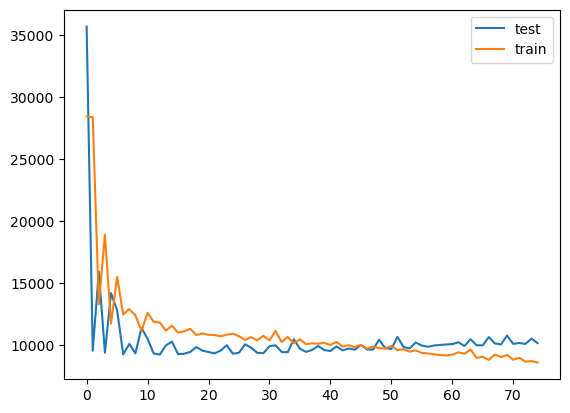

In [125]:
plt.plot(range(n_epochs),raw_history.history['val_mse'], label="test")
plt.plot(range(n_epochs),raw_history.history['mse'], label="train")
plt.legend()

In [126]:
y_pred = fc_model_raw.predict(x_flat)

5/5 [==============================] - 0s 18ms/step


2023-03-02 18:56:18.575030: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


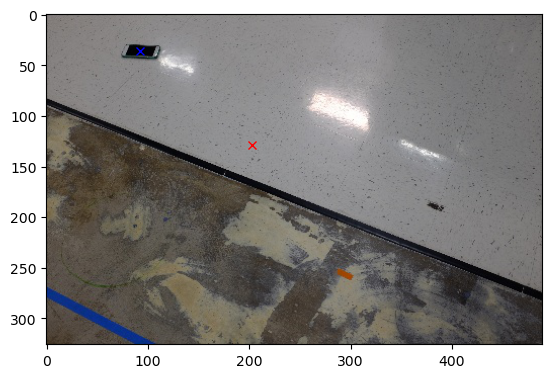

In [127]:
idx = 10
plt.plot([y_scaled[idx,0]], [y_scaled[idx,1]],'bx')
plt.plot([y_pred[idx,0]], [y_pred[idx,1]],'rx')
plt.imshow(x_flat[idx].reshape(326,490,3), cmap="gray")

## 3. Transfer Learning

### 3.1) InceptionV3

In [28]:
inception = tf.keras.applications.InceptionV3(weights='imagenet',include_top=False, 
                                              input_shape=x.shape[1:])

In [29]:
inception.trainable = True
last_layer = inception.get_layer('mixed10')
layer_output = last_layer.output
layer_output

<KerasTensor: shape=(None, 8, 13, 2048) dtype=float32 (created by layer 'mixed10')>

In [43]:
# Dense model architecture
x1 = layers.Flatten()(layer_output)
x1 = layers.Dropout(0.3)(x1)
x1 = layers.Dense(4112, activation="relu")(x1)
x1 = layers.Dense(1028, activation="relu")(x1)
x1 = layers.Dense(1028, activation="relu")(x1)
x1 = layers.Dropout(0.5)(x1)
x1 = layers.Dense(256, activation="relu")(x1)
coordinates = layers.Dense(2, name="coordinates")(x1)

model = tf.keras.Model(inputs=inception.inputs, outputs=coordinates)

In [38]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 326, 490, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 162, 244, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 162, 244, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                           

 conv2d_105 (Conv2D)            (None, 38, 58, 32)   6144        ['average_pooling2d_9[0][0]']    
                                                                                                  
 batch_normalization_99 (BatchN  (None, 38, 58, 64)  192         ['conv2d_99[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_101 (Batch  (None, 38, 58, 64)  192         ['conv2d_101[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_104 (Batch  (None, 38, 58, 96)  288         ['conv2d_104[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 conv2d_116 (Conv2D)            (None, 38, 58, 64)   18432       ['mixed1[0][0]']                 
                                                                                                  
 batch_normalization_116 (Batch  (None, 38, 58, 64)  192         ['conv2d_116[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_116 (Activation)    (None, 38, 58, 64)   0           ['batch_normalization_116[0][0]']
                                                                                                  
 conv2d_114 (Conv2D)            (None, 38, 58, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_11

                                                                                                  
 activation_123 (Activation)    (None, 18, 28, 96)   0           ['batch_normalization_123[0][0]']
                                                                                                  
 max_pooling2d_6 (MaxPooling2D)  (None, 18, 28, 288)  0          ['mixed2[0][0]']                 
                                                                                                  
 mixed3 (Concatenate)           (None, 18, 28, 768)  0           ['activation_120[0][0]',         
                                                                  'activation_123[0][0]',         
                                                                  'max_pooling2d_6[0][0]']        
                                                                                                  
 conv2d_128 (Conv2D)            (None, 18, 28, 128)  98304       ['mixed3[0][0]']                 
          

                                                                  'activation_127[0][0]',         
                                                                  'activation_132[0][0]',         
                                                                  'activation_133[0][0]']         
                                                                                                  
 conv2d_138 (Conv2D)            (None, 18, 28, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_138 (Batch  (None, 18, 28, 160)  480        ['conv2d_138[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_138 (Activation)    (None, 18, 28, 160)  0           ['batch_normalization_138[0][0]']
          

                                                                                                  
 batch_normalization_148 (Batch  (None, 18, 28, 160)  480        ['conv2d_148[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_148 (Activation)    (None, 18, 28, 160)  0           ['batch_normalization_148[0][0]']
                                                                                                  
 conv2d_149 (Conv2D)            (None, 18, 28, 160)  179200      ['activation_148[0][0]']         
                                                                                                  
 batch_normalization_149 (Batch  (None, 18, 28, 160)  480        ['conv2d_149[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 conv2d_159 (Conv2D)            (None, 18, 28, 192)  258048      ['activation_158[0][0]']         
                                                                                                  
 batch_normalization_159 (Batch  (None, 18, 28, 192)  576        ['conv2d_159[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_159 (Activation)    (None, 18, 28, 192)  0           ['batch_normalization_159[0][0]']
                                                                                                  
 conv2d_155 (Conv2D)            (None, 18, 28, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_16

                                                                                                  
 activation_167 (Activation)    (None, 18, 28, 192)  0           ['batch_normalization_167[0][0]']
                                                                                                  
 conv2d_164 (Conv2D)            (None, 18, 28, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_168 (Conv2D)            (None, 18, 28, 192)  258048      ['activation_167[0][0]']         
                                                                                                  
 batch_normalization_164 (Batch  (None, 18, 28, 192)  576        ['conv2d_164[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_nor

 conv2d_178 (Conv2D)            (None, 8, 13, 192)   245760      ['average_pooling2d_16[0][0]']   
                                                                                                  
 batch_normalization_170 (Batch  (None, 8, 13, 320)  960         ['conv2d_170[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_172 (Activation)    (None, 8, 13, 384)   0           ['batch_normalization_172[0][0]']
                                                                                                  
 activation_173 (Activation)    (None, 8, 13, 384)   0           ['batch_normalization_173[0][0]']
                                                                                                  
 activation_176 (Activation)    (None, 8, 13, 384)   0           ['batch_normalization_176[0][0]']
          

                                                                                                  
 activation_182 (Activation)    (None, 8, 13, 384)   0           ['batch_normalization_182[0][0]']
                                                                                                  
 activation_185 (Activation)    (None, 8, 13, 384)   0           ['batch_normalization_185[0][0]']
                                                                                                  
 activation_186 (Activation)    (None, 8, 13, 384)   0           ['batch_normalization_186[0][0]']
                                                                                                  
 batch_normalization_187 (Batch  (None, 8, 13, 192)  576         ['conv2d_187[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

In [39]:
# Applying learning rate decay after say 40 epochs
def scheduler(epoch, lr):
    if epoch<40:
        return lr
    else:
        return lr*tf.math.exp(-0.12)
    
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [44]:
# Complining the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
             loss = {'coordinates':'mse'},
             metrics={'coordinates':'mse'})

In [41]:
# Split the data into training and testing
x_train, y_train, x_test, y_test = split_data(x, y_scaled, test_frac=0.2)
x_train.shape, x_test.shape

((103, 326, 490, 3), (26, 326, 490, 3))

In [45]:
# Train the model
n_epochs = 70
hist = model.fit(x_train, y_train,
                epochs=n_epochs,
                validation_data=(x_test,y_test),
                callbacks=[callback])

Epoch 1/70


2023-03-03 09:46:47.165630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 35646.9219 - mse: 74852.7031 

2023-03-03 09:47:52.677787: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 71s 16s/step - loss: 35646.9219 - mse: 74852.7031 - val_loss: 53173.8906 - val_mse: 53173.8906 - lr: 0.0010
Epoch 2/70
4/4 [==============================] - 61s 14s/step - loss: 51596.0742 - mse: 51596.0742 - val_loss: 53172.3672 - val_mse: 53172.3672 - lr: 0.0010
Epoch 3/70
4/4 [==============================] - 65s 15s/step - loss: 51594.5703 - mse: 51594.5703 - val_loss: 53170.7617 - val_mse: 53170.7617 - lr: 0.0010
Epoch 4/70
4/4 [==============================] - 68s 16s/step - loss: 51593.0117 - mse: 51593.0117 - val_loss: 53169.1367 - val_mse: 53169.1367 - lr: 0.0010
Epoch 5/70
4/4 [==============================] - 58s 13s/step - loss: 51591.4141 - mse: 51591.4141 - val_loss: 53167.4922 - val_mse: 53167.4883 - lr: 0.0010
Epoch 6/70
4/4 [==============================] - 61s 14s/step - loss: 51589.8125 - mse: 51589.8125 - val_loss: 53165.8242 - val_mse: 53165.8203 - lr: 0.0010
Epoch 7/70
4/4 [==============================] - 63s 15s/step 

KeyboardInterrupt: 

## Utility Function

In [10]:
def split_data(x,y,test_frac=0.3):
    n = x.shape[0]
    shuffle_idx = np.random.permutation(range(n))
    idx = int(n*(1-test_frac))
    train_idx, test_idx = shuffle_idx[:idx], shuffle_idx[idx:]
    
    return x[train_idx],y[train_idx],x[test_idx],y[test_idx]

In [11]:
# Type could be "FC"
def build_model(type,input_shape):
    if type=="FC":
        model = tf.keras.Sequential([
            layers.Dense(8,activation='relu',input_shape=[input_shape[1]]),
            layers.Dense(8,activation='relu'),
#             layers.Dropout(0.25),
#             layers.Dense(64,activation='relu'),
            layers.Dense(2)
        ])
        
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss="mse",
                         optimizer=optimizer,
                          metrics=['mse']
                         )
        
    return model